In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Changing the directory
%cd '/content/drive/MyDrive/DSGP'

/content/drive/MyDrive/DSGP


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report

In [ ]:
# Load Data with Updated Paths
def load_data(images_path, masks_path):
    images = np.load(images_path)
    masks = np.load(masks_path)
    return images, masks

# Updated paths
train_images, train_masks = load_data("split_datasets/train_images.npy", "split_datasets/train_masks.npy")
val_images, val_masks = load_data("split_datasets/val_images.npy", "split_datasets/val_masks.npy")
test_images, test_masks = load_data("split_datasets/test_images.npy", "split_datasets/test_masks.npy")

In [ ]:
print(np.unique(train_masks))


[0. 1.]


In [ ]:
# 5. Preprocessing Function (Updated: Removed redundant normalization)
def preprocess_images_masks(images, masks, is_binary=True):
    images_out = images.astype("float32")
    masks_out = masks.astype("float32")

    if is_binary:
        masks_out[masks_out > 0] = 1.0  # Keep mask binarization

    masks_out = np.expand_dims(masks_out, axis=-1)  # Ensure shape (H, W, 1)
    return images_out, masks_out

# Apply preprocessing (without redundant normalization)
train_images, train_masks = preprocess_images_masks(train_images, train_masks, True)
val_images, val_masks = preprocess_images_masks(val_images, val_masks, True)
test_images, test_masks = preprocess_images_masks(test_images, test_masks, True)


In [ ]:
def random_augment(img, mask):
    # Horizontal flip with 50% chance
    if tf.random.uniform([]) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Slight random brightness
    img = tf.image.random_brightness(img, max_delta=0.05)

    return img, mask

def build_dataset(images, masks, batch_size=4, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: random_augment(x, y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_images, train_masks, batch_size=4, augment=True,  shuffle=True)
val_ds   = build_dataset(val_images,   val_masks,   batch_size=4, augment=False, shuffle=False)
test_ds  = build_dataset(test_images,  test_masks,  batch_size=4, augment=False, shuffle=False)

In [ ]:
def fcn_8(num_classes=1, input_shape=(512, 512, 3)):
    # Load VGG16 as encoder
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Extract important layers
    pool3 = vgg.get_layer("block3_pool").output
    pool4 = vgg.get_layer("block4_pool").output
    pool5 = vgg.get_layer("block5_pool").output

    # 1x1 conv on pool5
    score_pool5 = layers.Conv2D(num_classes, (1,1), padding='same')(pool5)
    up_pool5    = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2,
                                         padding='same', use_bias=False)(score_pool5)

    # 1x1 conv on pool4
    score_pool4 = layers.Conv2D(num_classes, (1,1), padding='same')(pool4)
    add_pool4   = layers.Add()([up_pool5, score_pool4])
    up_pool4    = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2,
                                         padding='same', use_bias=False)(add_pool4)

    # 1x1 conv on pool3
    score_pool3 = layers.Conv2D(num_classes, (1,1), padding='same')(pool3)
    add_pool3   = layers.Add()([up_pool4, score_pool3])

    # Final upsampling to match input size
    up_final = layers.Conv2DTranspose(num_classes, kernel_size=16, strides=8,
                                      padding='same', use_bias=False)(add_pool3)

    # Sigmoid for single-channel binary segmentation
    x = layers.Activation('sigmoid')(up_final)

    return Model(inputs=vgg.input, outputs=x, name="FCN-8")

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # Intersection
    intersection = K.sum(y_true_f * y_pred_f)
    # Dice score
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    # Standard binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # Dice loss
    dsc = dice_loss(y_true, y_pred)
    # Combine
    return bce + dsc

In [ ]:
# Learning Rate Optimization
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
def train_fcn8(
    train_ds, val_ds,
    input_shape=(512, 512, 3),
    num_classes=1,
    learning_rate=5e-4,
    epochs=20
):
    model = fcn_8(num_classes=num_classes, input_shape=input_shape)

    # Compile with custom BCE+Dice loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=bce_dice_loss,
        metrics=['accuracy', dice_coefficient]
    )

    # Train
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    return model, history

In [ ]:
model, history = train_fcn8(train_ds, val_ds, epochs=20, learning_rate=5e-4)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 424ms/step - accuracy: 0.5654 - dice_coefficient: 0.0095 - loss: 1.7092 - val_accuracy: 0.9044 - val_dice_coefficient: 0.0099 - val_loss: 1.2615
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.9631 - dice_coefficient: 0.0105 - loss: 1.1290 - val_accuracy: 0.9901 - val_dice_coefficient: 0.0472 - val_loss: 0.9946
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.9874 - dice_coefficient: 0.0548 - loss: 0.9978 - val_accuracy: 0.9863 - val_dice_coefficient: 0.1931 - val_loss: 0.8420
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.9893 - dice_coefficient: 0.1384 - loss: 0.9087 - val_accuracy: 0.9902 - val_dice_coefficient: 0.2323 - val_loss: 0.8015
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9907 - dice_coefficient: 0.1452 - loss: 0.9011 - val_accuracy: 0.9914 - val_dice_coefficient: 0.3027 - val_loss: 0.7274
Epoc

In [ ]:
test_loss, test_acc, test_dice = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Dice Coefficient:", test_dice)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.9940 - dice_coefficient: 0.5575 - loss: 0.4795
Test Loss: 0.4818105697631836
Test Accuracy: 0.9933855533599854
Test Dice Coefficient: 0.5551719069480896


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


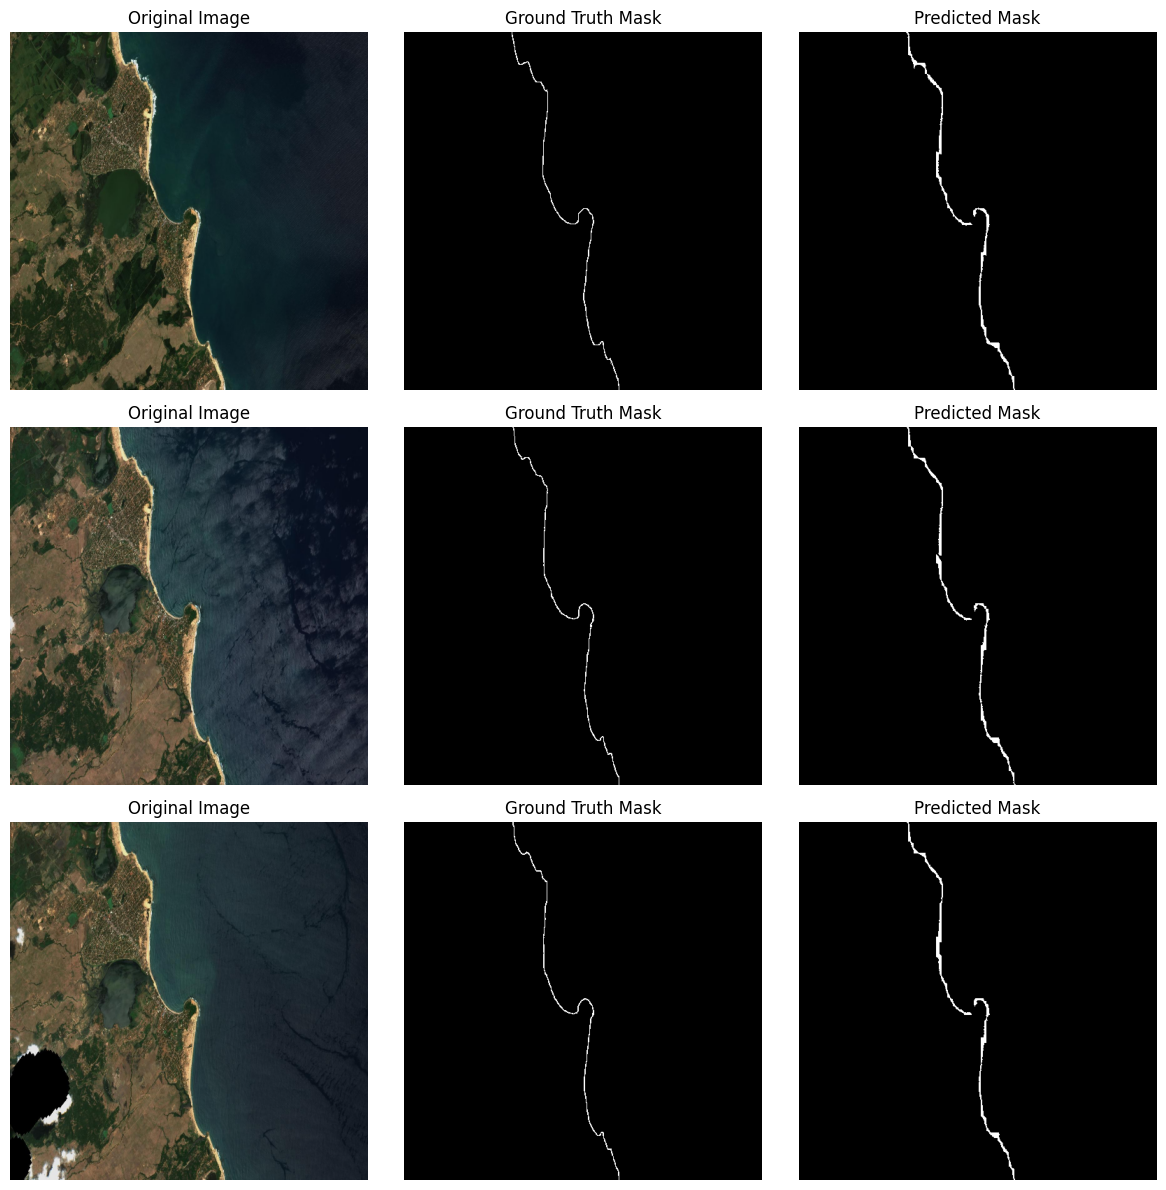

In [ ]:
# Display Predictions
def display_predictions(model, dataset, num_samples=3, threshold=0.5):
    for images, true_masks in dataset.take(1):
        predictions = model.predict(images)
        pred_masks = (predictions > threshold).astype(np.uint8)
        images_np = images.numpy()
        true_masks_np = true_masks.numpy()
        n = min(num_samples, images.shape[0])
        plt.figure(figsize=(12, 4*n))
        for i in range(n):
            plt.subplot(n, 3, 3*i + 1)
            plt.imshow(images_np[i])
            plt.title("Original Image")
            plt.axis("off")
            plt.subplot(n, 3, 3*i + 2)
            plt.imshow(true_masks_np[i].squeeze(), cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")
            plt.subplot(n, 3, 3*i + 3)
            plt.imshow(pred_masks[i].squeeze(), cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        break

display_predictions(model, test_ds, num_samples=3)

In [ ]:
model.save('/content/drive/MyDrive/DSGP/fcn8_model.h5')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
Classification Report:
               precision    recall  f1-score   support

  Background       1.00      0.99      1.00  25829305
      Object       0.41      0.88      0.56    122951

    accuracy                           0.99  25952256
   macro avg       0.70      0.93      0.78  25952256
weighted avg       1.00      0.99      0.99  25952256

Dice Score: 0.55632466
IoU Score: 0.38535303259258197


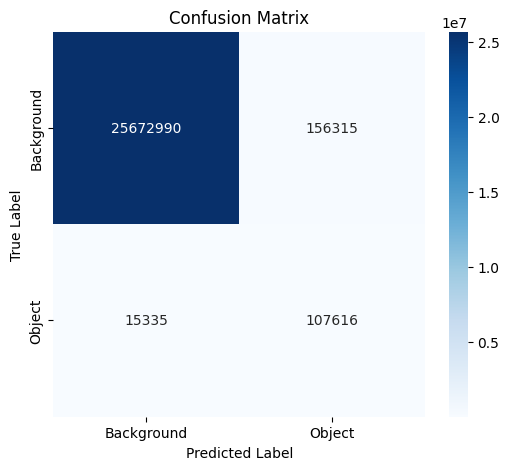

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score

# Ensure predictions are on the correct datatype
test_masks_float = tf.convert_to_tensor(test_masks, dtype=tf.float32)
y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

# Convert to float32 for TensorFlow computations
y_pred_binary_float = tf.convert_to_tensor(y_pred_binary, dtype=tf.float32)

# Flatten masks for classification report and confusion matrix
y_true_flat = test_masks.flatten()
y_pred_flat = y_pred_binary.flatten()

# Compute classification report
class_report = classification_report(y_true_flat, y_pred_flat, target_names=["Background", "Object"])
print("Classification Report:\n", class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Compute Dice Score
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

dice_score = dice_coefficient(test_masks_float, y_pred_binary_float).numpy()
print("Dice Score:", dice_score)

# Compute Intersection over Union (IoU)
iou_score = jaccard_score(y_true_flat, y_pred_flat, average='binary')
print("IoU Score:", iou_score)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Object"], yticklabels=["Background", "Object"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 9. Save and Load Model
model.save("fcn8_segmentation.h5")
loaded_model = tf.keras.models.load_model("fcn8_segmentation.h5")

In [ ]:
print("Train Image Shape:", train_images.shape)
print("Min Pixel Value:", np.min(train_images))
print("Max Pixel Value:", np.max(train_images))


Train Image Shape: (435, 512, 512, 3)
Min Pixel Value: 0.0
Max Pixel Value: 1.0


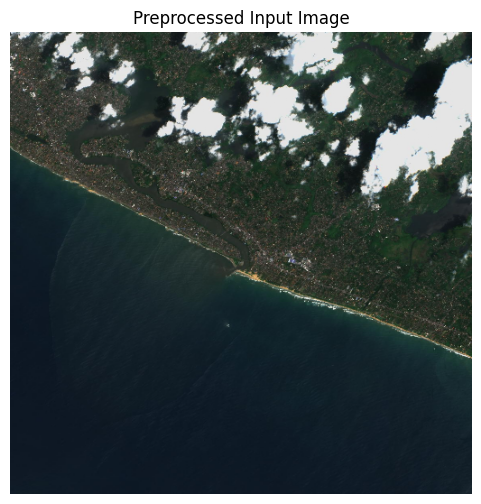

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the preprocessed image
input_image = np.load("/content/preprocessed_image.npy")

# Remove batch dimension (if needed)
image_to_plot = input_image[0]

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image_to_plot)
plt.title("Preprocessed Input Image")
plt.axis("off")
plt.show()


In [ ]:
pred_mask = model.predict(input_image)  # Get model prediction

# Remove batch dimension
pred_mask = pred_mask[0, :, :, 0]  # If using a binary segmentation model


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


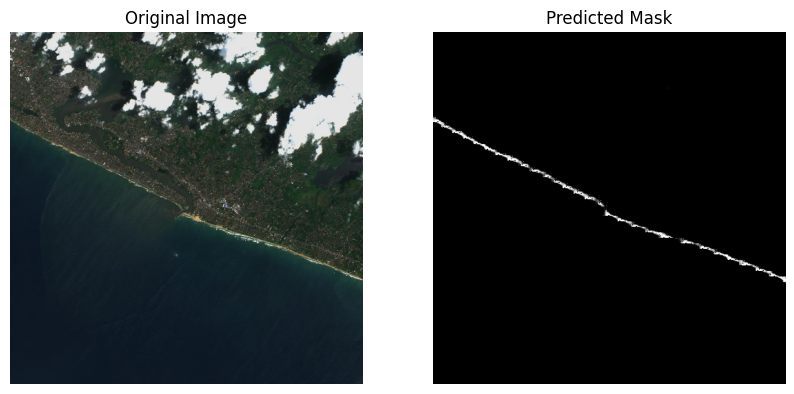

In [ ]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image_to_plot)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
